# Clasificación mediante Regresión lineal

En este cuaderno vamos a:
+ ver que clasificación y regresión son en realidad la misma tarea supervisada, pero en regresión hay infinitas etiquetas
+ comprender los parámetros de un clasificador lineal
+ añadir regularizadores a la función de coste

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2020, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2020, URJC (Spain)

    alfredo.cuesta@urjc.es

### Preliminares 

En la siguiente celda se realizan los siguientes pasos:
1. carga de módulos genéricos
2. leer los datos y cargarlos en dataframes
2. extracción de características
2. separación en dos conjuntos: *train* y *test*
2. selección de 1 única característica y escalado a $[0,1]$.

Sólo vamos a utilizar *train* y *test* porque el objetivo de este cuaderno es aprender más sobre la regresión lineal. <br>
Para simplificar el código no se realiza ningún tipo de validación.

Vamos a **utilizar una sóla característica** porque queremos visualizar la regresión lineal como técnica de clasificación, y posteriormente extenderlo con la regresión logística. Si utilizaramos más de una característica no podríamos representarlo en un gráfico 2D

In [2]:
import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../../MyUtils/')
import MyUtils as my
seed = 1234 #<- random generator seed (comment to get randomness)

#-[1]. Load data from CSV and put all in a single dataframe 'FullSet'

FullSet_0 = pd.read_csv('../../Datasets/1000ceros.csv', header=None)
FullSet_1 = pd.read_csv('../../Datasets/1000unos.csv',  header=None)
FullSet = my.join_features_labels(FullSet_0,FullSet_1)

#-[2]. Convert the 'FullSet' of pixels into the set 'X_full' of features and get the set 'Y_full' of labels

theta = 0.5
X_full = my.mnist_features( FullSet.drop('label', axis=1), theta=theta )
Y_full = FullSet[['label']]

#-[3]. Split X_full into TRAIN and TEST 

from sklearn.model_selection import StratifiedShuffleSplit

test_size = 0.2
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)
for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

#-[4]. Select the features and fit a scaler to [0,1]

from sklearn.preprocessing import MinMaxScaler


feat_selec= ['area']
scaler = MinMaxScaler()

X = scaler.fit_transform(X_train[feat_selec])
Y = Y_train.values.ravel()

#---> X and Y are now numpy arrays ready to train a machine !!

### La regresión lineal
Ahora mismo nuestro conjunto de entrenamiento consiste en $\{X,Y\}$
+ $X$ es una columna con los valores del área que ocupa el rectángulo que enmarca cada cifra del dataset
+ $Y$ es la etiqueta (0 ó 1) de cada imagen

Si pintamos $X$ contra $Y$ podemos ver perfectamente:
+ los ejemplos que son de 0 y los que son de 1
+ que hay zonas donde se solapan ejemplos de 0 con ejemplos de 1

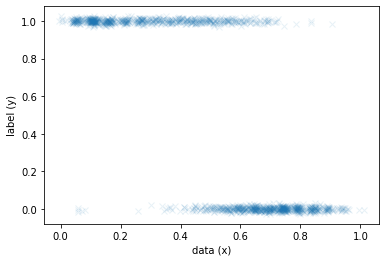

In [3]:
plt.plot(my.jitter(X,sigma=0.01), my.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

La recta de regresión ajustada por mínimos cuadrados es una recta que calculamos a partir de los datos

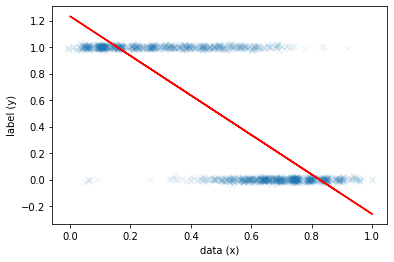

In [4]:
from sklearn.linear_model import LinearRegression

recta_regresion = LinearRegression()
recta_regresion.fit(X,Y) 
y_pred = recta_regresion.predict(X)

plt.plot(my.jitter(X,sigma=0.01), my.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.plot(X,y_pred,'r')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

Las predicciones de una recta, cuando le damos valores entre 0 y 1, son valores continuos. <br>
Pero nosotros necesitamos asignar una etiqueta **¡ discreta !** <br>
$\rightarrow$ **nos falta la función discriminante**
$$
\hat{y} =  
   \begin{cases}
    1 & \text{si } f(x; m,b)  < \theta \\
    0 & \text{otro caso} \\
  \end{cases}
$$
donde $f(x; m,b)$ es la recta de regresión obtenida con los datos $x$, y cuyos parámetros son $m$ (la pendiente) y $b$ (el corte con el eje vertical)

Por tanto el discriminante depende de $\theta$.

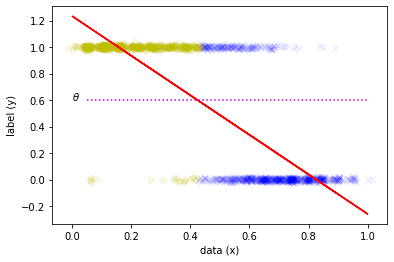

In [5]:
theta = 0.6 #<-- paramter of the discriminant function

ix_1 = y_pred < theta
ix_0 = ~ix_1
plt.plot( my.jitter(X[ix_1],sigma=0.01), \
          my.jitter(Y[ix_1],sigma=0.01), \
          'bx',alpha=0.1)
plt.plot( my.jitter(X[ix_0],sigma=0.01), \
          my.jitter(Y[ix_0],sigma=0.01), \
          'yo',alpha=0.1)
plt.text(0,theta, r'$ \theta $')
plt.plot(X,y_pred,'r')
plt.plot([0.05,1],[theta,theta],'m:')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Ejercicio
Comprobar que se obtiene la misma recta de regresión con la fórmula de ajuste de mínimos cuadrados.
$$ w^* = (X^T\cdot X)^{-1}X^T\cdot Y $$
donde $X$ es la matriz de datos extendida con una columna de unos a la izquierda.

### Solución

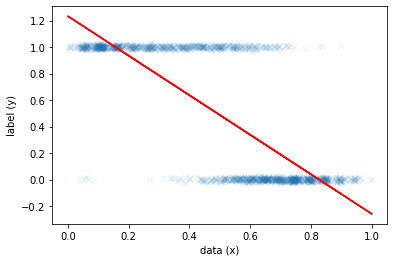

In [6]:
# fit y pred
X_ones = np.append(np.ones([X.size,1]), X, axis=1)
w = np.linalg.inv(X_ones.T.dot(X_ones)).dot(X_ones.T).dot(Y)
y_pred = w.dot(X_ones.T)

plt.plot(my.jitter(X,sigma=0.01), my.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.plot(X,y_pred,'r')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Ejercicio
Realmente utilizar un objeto `LinearRegression` es muy poco eficiente porque no nos permite utilizar los métodos para evaluar el rendimiento del clasificador (es obvio porque ese objeto es está pensado para hacer regresión). 

Para hacer clasificación lineal es preferible usar :

+ Perceptron
+ RidgeClassifier / RidgeClassifierCV
+ SGDClassifier

Probar a estimar un clasificador lineal con estos métodos y aprender en *Scikit-Learn* sus características.

### Solución

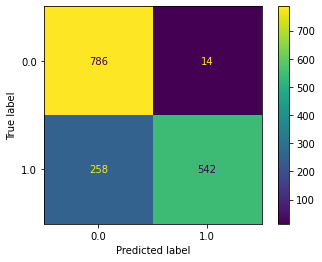

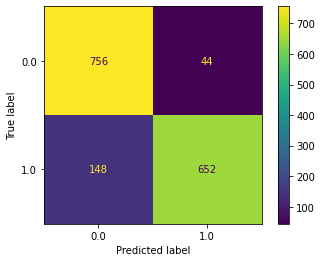

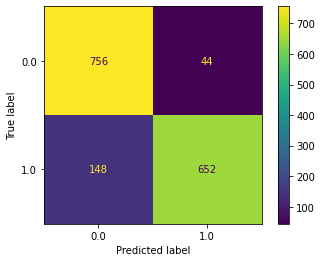

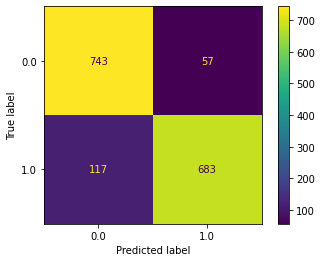

In [7]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import plot_confusion_matrix
clf = Perceptron()
clf.fit(X,Y)
plot_confusion_matrix(clf, X, Y)

from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier()
clf.fit(X,Y)
plot_confusion_matrix(clf,X,Y)

from sklearn.linear_model import RidgeClassifierCV
clf = RidgeClassifierCV()
clf.fit(X,Y)
plot_confusion_matrix(clf,X,Y)

from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
clf.fit(X,Y)
plot_confusion_matrix(clf,X,Y)